## [Description](#Description_)
## [Todo](#Todo_)
## [Research](#Research_)
## [Setup](#Setup_)
### - [Requirements](#Requirements_)
### - [Imports](#Imports_)
### - [Globals](#Globals_)
### - [Utils](#Utils_)
## [Data](#Data_)
### - [Annotation structure](#Annotation_structure_)
### - [Data exploration](#Data_exploration_)
### - [Data splits](#Data_splits_)
### - [Expected model output format](#Expected_model_output_format_)
### - [Metrics](#Metrics_)
### - [Dataset](#Dataset_)
## [Model](#Model_)
### - [Add task specific tokens](#Add_task_specific_tokens_)
### - [Add dataset specific tokens](#Add_dataset_specific_tokens_)
### - [Predicting](#Predicting_)
### - [Dataloader](#Dataloader_)
### - [Lightning module](#Lightning_module_)
### - [Callbacks](#Callbacks_)
## [Training](#Training_)
## [Results](#Results_)
### - [Gradio interface](#Gradio_interface_)

## Description <span id=Description_></span>

Trying my hand at this kaggle challenge:

https://www.kaggle.com/competitions/benetech-making-graphs-accessible

## Todo <span id=Todo_></span>

- Add wandb logs: metrics, images, text
- Create separate training script
- Train
- Get familiar with transformers library: main classes, how to work with config
- Do more research, check out notebooks in kaggle
- Check out dataset https://chartinfo.github.io/toolsanddata.html
- Try segmentation -> classification -> parsing pipeline
- Make predicting faster, check out https://pytorch.org/serve/

## Research <span id=Research_></span>

[Donut](https://arxiv.org/pdf/2111.15664.pdf) - document understanding transformer without the intermediate optical character recognition step.
[Example notebook one](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/CORD/Fine_tune_Donut_on_a_custom_dataset_(CORD)_with_PyTorch_Lightning.ipynb),
[example notebook two](https://www.kaggle.com/code/nbroad/donut-train-benetech).

## Setup <span id=Setup_></span>

### Imports <span id=Imports_></span>

In [1]:
%load_ext nb_black
%matplotlib inline


import collections
import dataclasses
import datasets
import einops
import enum
import gradio
import glob
import IPython
import imageio
import json
import functools
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
import pickle
import pprint
import pytorch_lightning as pl
import rapidfuzz
import re
import reprlib
import sklearn.metrics
import torch
import torchvision
import tqdm.autonotebook
import transformers
import types
from typing import Callable, Literal
import wandb

<IPython.core.display.Javascript object>

### Requirements

In [ ]:
def pip_freeze_requirements():
    !pip freeze > requirements.txt
    
#pip_freeze_requirements()

### Globals <span id=Globals_></span>

In [2]:
COMPETITION = "benetech-making-graphs-accessible"
DEBUG: bool = False
DATA = types.SimpleNamespace()
TOKEN = types.SimpleNamespace()
CONFIG = types.SimpleNamespace()
MODEL = types.SimpleNamespace()
TRAINING = types.SimpleNamespace()

<IPython.core.display.Javascript object>

### Markdown

In [3]:
def make_new_markdown_section_with_link(section, header="##", do_print=True):
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header


def make_several_sections(
    section_names=(
        "Description",
        "Imports",
        "Globals",
        "Setup",
        "Data",
        "Data exploration",
        "Model",
        "Training",
        "Results",
    )
):
    links, headers = zip(
        *[
            make_new_markdown_section_with_link(sn, do_print=False)
            for sn in section_names
        ]
    )
    print("\n".join(links + ("",) + headers))


<IPython.core.display.Javascript object>

### Terminal

In [4]:
def mkdir(path, error_if_exists=False):
    !mkdir {"-p" if not error_if_exists else ""} {path}


def unzip(zip_path, save_path=None, delete_zip=False):
    !unzip {zip_path} {"-d "+ save_path if save_path else ""}
    if delete_zip:
        for path in glob.glob(zip_path):
            if path.endswith(".zip"):
                !trash {path}


def unzip_to_data_and_delete():
    unzip("data/*", "data", delete_zip=True)

<IPython.core.display.Javascript object>

### Kaggle

In [5]:
def kaggle_competitions_search(search_term):
    !kaggle competitions list -s {search_term}


def kaggle_competitions_files(competition):
    !kaggle competitions files {competition}


def kaggle_competitions_download(competition, save_path="data", filename=None):
    mkdir(save_path)
    !kaggle competitions download -p {save_path} {"-f " + filename if filename else ""} {competition}


def kaggle_competitions_submit(competition, filename, message="submit"):
    !kaggle competitions submit -f {filename} -m {message} {competition}


def kaggle_competitions_submissions(competition):
    !kaggle competitions submissions {competition}

<IPython.core.display.Javascript object>

### Gpu server

In [7]:
def get_shad_server_username_and_telegram_id_pairs(
    copy_pasted_table: str or None = None,
) -> list[str, str]:
    table_url = "https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vRNGT6OeI7zKVFzYPoqmTPh1jCfeVjRLSvFziVgRleyFTOHi1GU39ERo_UixTGcgydG7QcurnSmHgSW/pubhtml?gid=1404550339&single=true"

    if copy_pasted_table is not None:
        table = copy_pasted_table
    else:
        home = os.environ["HOME"]
        table = open(f"{home}/shad_server_username_to_telegram.txt").read()

    shad_server_username_and_telegram_id_pairs = []
    for row in table.splitlines():
        if row.count("\t") == 0:
            continue
        cols = row.split("\t")
        shad_server_username = cols[-2]
        telegram_id = cols[-1]
        shad_server_username_and_telegram_id_pairs.append(
            (shad_server_username, telegram_id)
        )

    return shad_server_username_and_telegram_id_pairs


def get_nvidia_smi_pid_column():
    nvidia_smi_pid_column = !nvidia-smi | awk '{print $5}'
    return nvidia_smi_pid_column


def get_pid_username(pid: int) -> str:
    username = !ps -o uname= -p {pid}
    return username[0]


def get_usernames_using_gpu() -> list[str]:
    nvidia_smi_pid_column = get_nvidia_smi_pid_column()
    pids_using_gpu = []
    for row in nvidia_smi_pid_column[::-1]:
        if row == "PID":
            break
        try:
            pid = int(row)
        except ValueError:
            continue
        pids_using_gpu.append(int(pid))

    usernames_using_gpu = [get_pid_username(pid) for pid in pids_using_gpu]
    usernames_using_gpu = list(set(usernames_using_gpu))
    return usernames_using_gpu


def print_telegram_usernames_using_gpu(table: str or None = None):
    server_to_telegram = dict(get_shad_server_username_and_telegram_id_pairs(table))
    usernames_using_gpu = get_usernames_using_gpu()

    telegram_usernames_using_gpu = []
    server_usernames_with_unknown_telegram_id = []
    for username in usernames_using_gpu:
        if username in server_to_telegram:
            telegram_usernames_using_gpu.append(server_to_telegram[username])
        else:
            server_usernames_with_unknown_telegram_id.append(username)

    print("Telegram id of users using gpu:")
    print("\n".join(telegram_usernames_using_gpu))

    if server_usernames_with_unknown_telegram_id:
        print("Telegram id is unknown for users:")
        print("\n".join(server_usernames_with_unknown_telegram_id))

<IPython.core.display.Javascript object>

### Environment variables <span id=Environment_variables_></span>

In [6]:
def set_tokenizers_parallelism(enable: bool):
    os.environ["TOKENIZERS_PARALLELISM"] = "true" if enable else "false"


def set_torch_device_order_pci_bus():
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


set_tokenizers_parallelism(False)
set_torch_device_order_pci_bus()

<IPython.core.display.Javascript object>

### Utils <span id=Utils_></span>

In [ ]:
def path_to_dict(path, print_only_last_dirname=False):
    dirpath, dirnames, filenames = next(os.walk(path))
    path_contents = filenames

    for dirname in dirnames:
        full_dirname = os.path.join(path, dirname)
        path_contents.append(path_to_dict(full_dirname, print_only_last_dirname=True))

    if print_only_last_dirname:
        path = os.path.split(path)[-1]

    return {path: path_contents}


def pprint_path_contents(path):
    path_dict = path_to_dict(path)
    short_path_repr = reprlib.repr(path_dict)
    short_path_dict = eval(short_path_repr)
    string = pprint.pformat(short_path_dict).replace("Ellipsis", "...")
    print(string)
    
    
def load_pickle_or_build_object_and_save(pickle_path:str, build_object: Callable[[], "T"]) -> "T":
    if not os.path.exists(pickle_path):
        pickle.dump(build_object(), open(pickle_path, "wb"))
    else:
        print(f"Reusing object {pickle_path}.")
    return pickle.load(open(pickle_path, "rb"))

## Data <span id=Data_></span>

In [8]:
if not os.path.exists("data"):
    kaggle_competitions_download(COMPETITION)
    unzip_to_data_and_delete()

<IPython.core.display.Javascript object>

In [10]:
pprint_path_contents("data")

{'data': ['sample_submission.csv',
          {'train': [{'images': ['52ecbd029a07.jpg',
                                 'fd7e3f0e4d43.jpg',
                                 'f0122da6cbe1.jpg',
                                 '2a186a0fa1ae.jpg',
                                 '6559c7a7d153.jpg',
                                 '5fd880333d07.jpg',
                                 ...]},
                     {'annotations': ['0f4f52fc3f4b.json',
                                      '35f0ec146509.json',
                                      '2e374a37e404.json',
                                      '96578b79c571.json',
                                      'dfbd6e21c301.json',
                                      '0893be463049.json',
                                      ...]}]},
          {'test': [{'images': ['000b92c3b098.jpg',
                                '01b45b831589.jpg',
                                '00dcf883a459.jpg',
                                '007a18eb4e09.jpg'

<IPython.core.display.Javascript object>

In [11]:
@functools.cache
def load_train_image_ids() -> list[str]:
    train_image_ids = [i.replace(".jpg", "") for i in os.listdir("data/train/images")]
    return train_image_ids[: 1000 if DEBUG else None]


@functools.cache
def load_test_image_ids() -> list[str]:
    return [i.replace(".jpg", "") for i in os.listdir("data/test/images")]


@functools.cache
def load_image_annotation(image_id: str) -> dict:
    return json.load(open(f"data/train/annotations/{image_id}.json"))


def load_image(image_id: str) -> np.ndarray:
    return imageio.v3.imread(open(f"data/train/images/{image_id}.jpg", "rb"))

<IPython.core.display.Javascript object>

### Annotation structure <span id=Annotation_structure_></span>

In [12]:
class Source(enum.Enum):
    generated = "generated"
    extracted = "extracted"


class ChartType(enum.Enum):
    dot = "dot"
    horizontal_bar = "horizontal_bar"
    vertical_bar = "vertical_bar"
    line = "line"
    scatter = "scatter"


@dataclasses.dataclass
class PlotBoundingBox:
    height: int
    width: int
    x0: int
    y0: int

    def get_bounds(self):
        xs = [self.x0, self.x0 + self.width, self.x0 + self.width, self.x0, self.x0]
        ys = [self.y0, self.y0, self.y0 + self.height, self.y0 + self.height, self.y0]
        return xs, ys


@dataclasses.dataclass
class DataPoint:
    x: float or str
    y: float or str


class TextRole(enum.Enum):
    axis_title = "axis_title"
    chart_title = "chart_title"
    legend_label = "legend_label"
    tick_grouping = "tick_grouping"
    tick_label = "tick_label"
    other = "other"


@dataclasses.dataclass
class Polygon:
    x0: int
    x1: int
    x2: int
    x3: int
    y0: int
    y1: int
    y2: int
    y3: int

    def get_bounds(self):
        xs = [
            self.x0,
            self.x1,
            self.x2,
            self.x3,
            self.x0,
        ]
        ys = [
            self.y0,
            self.y1,
            self.y2,
            self.y3,
            self.y0,
        ]
        return xs, ys


@dataclasses.dataclass
class Text:
    id: int
    polygon: Polygon
    role: TextRole
    text: str

    def __post_init__(self):
        self.polygon = Polygon(**self.polygon)
        self.role = TextRole(self.role)


class ValuesType(enum.Enum):
    categorical = "categorical"
    numerical = "numerical"


@dataclasses.dataclass
class Tick:
    id: int
    x: int
    y: int


class TickType(enum.Enum):
    markers = "markers"
    separators = "separators"


@dataclasses.dataclass
class Axis:
    values_type: ValuesType
    tick_type: TickType
    ticks: list[Tick]

    def __post_init__(self):
        self.values_type = ValuesType(self.values_type)
        self.tick_type = TickType(self.tick_type)
        self.ticks = [
            Tick(id=kw["id"], x=kw["tick_pt"]["x"], y=kw["tick_pt"]["y"])
            for kw in self.ticks
        ]

    def get_bounds(self):
        min_x = min(tick.x for tick in self.ticks)
        max_x = max(tick.x for tick in self.ticks)
        min_y = min(tick.y for tick in self.ticks)
        max_y = max(tick.y for tick in self.ticks)
        xs = [min_x, max_x, max_x, min_x, min_x]
        ys = [min_y, min_y, max_y, max_y, min_y]
        return xs, ys


def convert_dashes_to_underscores_in_key_names(dictionary):
    return {k.replace("-", "_"): v for k, v in dictionary.items()}


@dataclasses.dataclass
class Axes:
    x_axis: Axis
    y_axis: Axis

    def __post_init__(self):
        self.x_axis = Axis(**convert_dashes_to_underscores_in_key_names(self.x_axis))
        self.y_axis = Axis(**convert_dashes_to_underscores_in_key_names(self.y_axis))


def preprocess_numerical_value(value):
    value = float(value)
    value = 0 if np.isnan(value) else value
    return value


def preprocess_value(value, value_type: ValuesType):
    if value_type == ValuesType.numerical:
        return preprocess_numerical_value(value)
    else:
        return str(value)


@dataclasses.dataclass
class Annotation:
    source: Source
    chart_type: ChartType
    plot_bb: PlotBoundingBox
    text: list[Text]
    axes: Axes
    data_series: list[DataPoint]

    def __post_init__(self):
        self.source = Source(self.source)
        self.chart_type = ChartType(self.chart_type)
        self.plot_bb = PlotBoundingBox(**self.plot_bb)
        self.text = [Text(**kw) for kw in self.text]
        self.axes = Axes(**convert_dashes_to_underscores_in_key_names(self.axes))
        self.data_series = [DataPoint(**kw) for kw in self.data_series]

        for i in range(len(self.data_series)):
            self.data_series[i].x = preprocess_value(
                self.data_series[i].x, self.axes.x_axis.values_type
            )
            self.data_series[i].y = preprocess_value(
                self.data_series[i].y, self.axes.y_axis.values_type
            )

    @staticmethod
    def from_dict_with_dashes(kwargs):
        return Annotation(**convert_dashes_to_underscores_in_key_names(kwargs))

    @staticmethod
    def from_image_index(image_index: int):
        image_id = load_train_image_ids()[image_index]
        return Annotation.from_dict_with_dashes(load_image_annotation(image_id))

    def get_text_by_role(self, text_role: TextRole) -> list[Text]:
        return [t for t in self.text if t.role == text_role]


@dataclasses.dataclass
class AnnotatedImage:
    id: str
    image: np.ndarray
    annotation: Annotation

    @staticmethod
    def from_image_id(image_id: str):
        return AnnotatedImage(
            id=image_id,
            image=load_image(image_id),
            annotation=Annotation.from_dict_with_dashes(
                load_image_annotation(image_id)
            ),
        )

    @staticmethod
    def from_image_index(image_index: int):
        return AnnotatedImage.from_image_id(load_train_image_ids()[image_index])


def generate_annotated_images():
    for image_id in tqdm.autonotebook.tqdm(
        load_train_image_ids(), "Iterating over annotated images"
    ):
        yield AnnotatedImage.from_image_id(image_id)

<IPython.core.display.Javascript object>

### Data exploration <span id=Data_exploration_></span>

In [13]:
def are_there_nan_values_in_axis_data():
    for annotated_image in generate_annotated_images():
        for datapoint in annotated_image.annotation.data_series:
            for value in [datapoint.x, datapoint.y]:
                if not isinstance(value, str) and np.isnan(value):
                    return True
    return False

<IPython.core.display.Javascript object>

In [14]:
if DEBUG:
    print(are_there_nan_values_in_axis_data())

<IPython.core.display.Javascript object>

In [15]:
def get_image(image_index: int) -> np.ndarray:
    return load_image(load_train_image_ids()[image_index])


def build_random_image_animation(n_images=100, fps=1, figsize=(6, 4)):
    image_indices = np.random.permutation(len(load_train_image_ids()))[:n_images]
    first_image = get_image(image_indices[0])

    fig, ax = plt.subplots(figsize=figsize)
    frame = plt.imshow(first_image)
    plt.axis("off")
    plt.close()

    def animate(frame_index):
        image_index = image_indices[frame_index]
        image = get_image(image_index)
        frame.set_data(image)

    return matplotlib.animation.FuncAnimation(
        fig=fig,
        func=animate,
        frames=len(image_indices),
        interval=int(1000 / fps),
    )

<IPython.core.display.Javascript object>

In [16]:
IPython.display.HTML(build_random_image_animation().to_html5_video())

<IPython.core.display.Javascript object>

In [17]:
def visualize_image_stats(figsize=(12, 8)):
    image_shapes = [ai.image.shape for ai in generate_annotated_images()]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    height, width, channel = zip(*image_shapes)

    IPython.display.display(
        pd.DataFrame(dict(width=width, height=height, channel=channel)).describe()
    )

    plt.sca(axes[0][0])
    plt.title("Image shapes")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.scatter(
        width,
        height,
        marker=".",
        alpha=0.3,
    )
    plt.grid()

    plt.sca(axes[0][1])
    plt.title("Width")
    plt.hist(width, bins=50)
    plt.grid()

    plt.sca(axes[1][0])
    plt.title("Height")
    plt.hist(height, bins=50)
    plt.grid()

    plt.sca(axes[1][1])
    plt.axis("off")

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [18]:
if DEBUG:
    visualize_image_stats()

<IPython.core.display.Javascript object>

In [19]:
CONFIG.image_width = 720
CONFIG.image_height = 512

<IPython.core.display.Javascript object>

In [20]:
def plot_image_with_annotations(image_id: str, show_categorical_data=True):
    annotated_image = AnnotatedImage.from_image_id(image_id)
    annotation = annotated_image.annotation
    image = annotated_image.image
    plt.subplots(figsize=(8, 6))
    plt.imshow(image)

    if show_categorical_data:
        IPython.display.display(
            pd.Series(
                dict(
                    source=annotation.source.value,
                    chart_type=annotation.chart_type.value,
                    x_values_type=annotation.axes.x_axis.values_type.value,
                    y_values_type=annotation.axes.y_axis.values_type.value,
                    x_tick_type=annotation.axes.x_axis.tick_type.value,
                    y_tick_type=annotation.axes.y_axis.tick_type.value,
                )
            )
        )

    plt.plot(*annotation.plot_bb.get_bounds(), c="red", label="bounding_box")

    plt.scatter(
        *list(zip(*[[tick.x, tick.y] for tick in annotation.axes.x_axis.ticks])),
        label="x_ticks"
    )
    plt.scatter(
        *list(zip(*[[tick.x, tick.y] for tick in annotation.axes.y_axis.ticks])),
        label="y_ticks"
    )

    text_role_colors = dict(zip(TextRole, plt.cm.Accent.colors))
    seen_roles = set()
    for i, text in enumerate(annotation.text):
        xs = [
            text.polygon.x0,
            text.polygon.x1,
            text.polygon.x2,
            text.polygon.x3,
            text.polygon.x0,
        ]
        ys = [
            text.polygon.y0,
            text.polygon.y1,
            text.polygon.y2,
            text.polygon.y3,
            text.polygon.y0,
        ]
        plt.plot(
            xs,
            ys,
            c=text_role_colors[text.role],
            label=text.role.value if text.role not in seen_roles else None,
        )
        seen_roles.add(text.role)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

<IPython.core.display.Javascript object>

source             generated
chart_type              line
x_values_type    categorical
y_values_type      numerical
x_tick_type          markers
y_tick_type          markers
dtype: object

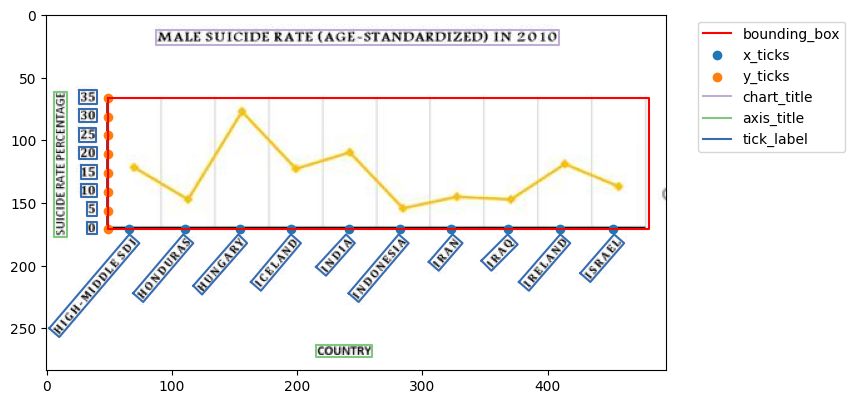

<IPython.core.display.Javascript object>

In [21]:
plot_image_with_annotations(np.random.choice(load_train_image_ids()))

### Data splits <span id=Data_splits_></span>

In [22]:
def split_train_indices_by_source():
    extracted_image_indices = []
    generated_image_indices = []
    for i, annotated_image in enumerate(generate_annotated_images()):
        if annotated_image.annotation.source == Source.extracted:
            extracted_image_indices.append(i)
        else:
            generated_image_indices.append(i)
    return extracted_image_indices, generated_image_indices


def get_train_val_split_indices(val_fraction=0.1, seed=42):
    np.random.seed(42)
    val_size = int(len(load_train_image_ids()) * val_fraction)

    extracted_image_indices, generated_image_indices = split_train_indices_by_source()
    extracted_image_indices = np.random.permutation(extracted_image_indices)
    generated_image_indices = np.random.permutation(generated_image_indices)

    val_indices = extracted_image_indices[:val_size]
    n_generated_images_in_val = val_size - len(val_indices)
    val_indices = np.concatenate(
        [val_indices, generated_image_indices[:n_generated_images_in_val]]
    )

    train_indices = generated_image_indices[n_generated_images_in_val:]

    assert len(set(train_indices) | set(val_indices)) == len(load_train_image_ids())
    assert len(val_indices) == val_size
    assert len(set(train_indices) & set(val_indices)) == 0

    return train_indices, val_indices

<IPython.core.display.Javascript object>

In [23]:
CONFIG.val_fraction = 0.1
CONFIG.seed = 42
CONFIG.train_val_indices_path = "data/train_val_indices.pickle"

DATA.train_indices, DATA.val_indices = load_pickle_or_build_object_and_save(
    CONFIG.train_val_indices_path,
    lambda : get_train_val_split_indices(CONFIG.val_fraction, CONFIG.seed)
)

Reusing split indices.


<IPython.core.display.Javascript object>

### Expected model output format <span id=Expected_model_output_format_></span>

In [24]:
pd.read_csv("data/sample_submission.csv").head(4)

,id,data_series,chart_type
0,000b92c3b098_x,abc;def,vertical_bar
1,000b92c3b098_y,0.0;1.0,vertical_bar
2,007a18eb4e09_x,abc;def,vertical_bar
3,007a18eb4e09_y,0.0;1.0,vertical_bar


<IPython.core.display.Javascript object>

In the Benetech competition I need to predict chart type and axis values, so I will create appropriate tokens and later add them to the transformer.

In [25]:
def to_token_str(value: str or enum.Enum):
    string = value.name if isinstance(value, enum.Enum) else value
    if re.fullmatch("<.*>", string):
        return string
    else:
        return f"<{string}>"


TOKEN.benetech_prompt = to_token_str("benetech_prompt")
TOKEN.benetech_prompt_end = to_token_str("/benetech_prompt")

for chart_type in ChartType:
    setattr(TOKEN, chart_type.name, to_token_str(chart_type))

for values_type in ValuesType:
    setattr(TOKEN, values_type.name, to_token_str(values_type))

TOKEN.x_start = to_token_str("x_start")
TOKEN.y_start = to_token_str("y_start")
TOKEN.value_separator = to_token_str(";")

<IPython.core.display.Javascript object>

In [26]:
CONFIG.float_scientific_notation_string_precision = 5


def convert_number_to_scientific_string(value: int or float) -> str:
    return f"{value:.{CONFIG.float_scientific_notation_string_precision}e}"


def convert_axis_data_to_string(
    axis_data: list[str or float], values_type: ValuesType
) -> str:
    formatted_axis_data = []
    for value in axis_data:
        if values_type == ValuesType.numerical:
            value = convert_number_to_scientific_string(value)
        formatted_axis_data.append(value)
    return TOKEN.value_separator.join(formatted_axis_data)


def convert_string_to_axis_data(string, values_type: ValuesType):
    data = string.split(TOKEN.value_separator)
    if values_type == ValuesType.numerical:
        data = [float(i) for i in data]
    return data


def compute_numeric_data_loss_due_to_string_conversion():
    squared_error = 0
    n_numeric_values = 0
    for annotated_image in generate_annotated_images():
        annotation = annotated_image.annotation
        for axis, data in zip(
            [annotation.axes.x_axis, annotation.axes.y_axis],
            [
                [dp.x for dp in annotation.data_series],
                [dp.y for dp in annotation.data_series],
            ],
        ):
            if axis.values_type == ValuesType.numerical:
                string = convert_axis_data_to_string(data, ValuesType.numerical)
                reconverted_data = convert_string_to_axis_data(
                    string, ValuesType.numerical
                )
                squared_error += (
                    (np.array(data) - np.array(reconverted_data)) ** 2
                ).sum()
                n_numeric_values += len(data)

    mse = squared_error**0.5 / n_numeric_values
    return mse

<IPython.core.display.Javascript object>

In [27]:
if DEBUG:
    print(compute_numeric_data_loss_due_to_string_conversion())

<IPython.core.display.Javascript object>

In [28]:
@dataclasses.dataclass
class BenetechOutput:
    chart_type: ChartType
    x_values_type: ValuesType
    y_values_type: ValuesType
    x_data: list[str or float]
    y_data: list[str or float]

    def __post_init__(self):
        self.chart_type = ChartType(self.chart_type)
        self.x_values_type = ValuesType(self.x_values_type)
        self.y_values_type = ValuesType(self.y_values_type)
        assert isinstance(self.x_data, list)
        assert isinstance(self.y_data, list)

    def get_main_characteristics(self):
        return (
            self.chart_type,
            self.x_values_type,
            self.y_values_type,
            len(self.x_data),
            len(self.y_data),
        )

    @staticmethod
    def from_annotation(annotation: Annotation):
        return BenetechOutput(
            chart_type=annotation.chart_type,
            x_values_type=annotation.axes.x_axis.values_type,
            y_values_type=annotation.axes.y_axis.values_type,
            x_data=[dp.x for dp in annotation.data_series],
            y_data=[dp.y for dp in annotation.data_series],
        )

    def to_string(self):
        return self.format_strings(
            chart_type=self.chart_type,
            x_values_type=self.x_values_type,
            y_values_type=self.y_values_type,
            x_data=convert_axis_data_to_string(self.x_data, self.x_values_type),
            y_data=convert_axis_data_to_string(self.y_data, self.y_values_type),
        )

    @staticmethod
    def format_strings(*, chart_type, x_values_type, y_values_type, x_data, y_data):
        chart_type = to_token_str(chart_type)
        x_values_type = to_token_str(x_values_type)
        y_values_type = to_token_str(y_values_type)
        return (
            f"{TOKEN.benetech_prompt}{chart_type}"
            f"{TOKEN.x_start}{x_values_type}{x_data}"
            f"{TOKEN.y_start}{y_values_type}{y_data}"
            f"{TOKEN.benetech_prompt_end}"
        )

    @staticmethod
    def get_string_pattern():
        field_names = [field.name for field in dataclasses.fields(BenetechOutput)]
        pattern = BenetechOutput.format_strings(
            **{field_name: f"(?P<{field_name}>.*?)" for field_name in field_names}
        )
        return pattern

    @staticmethod
    def does_string_match_expected_pattern(string):
        return bool(re.fullmatch(BenetechOutput.get_string_pattern(), string))

    @staticmethod
    def from_string(string):
        fullmatch = re.fullmatch(BenetechOutput.get_string_pattern(), string)
        benetech_kwargs = fullmatch.groupdict()
        benetech_kwargs["chart_type"] = ChartType(benetech_kwargs["chart_type"])
        benetech_kwargs["x_values_type"] = ValuesType(benetech_kwargs["x_values_type"])
        benetech_kwargs["y_values_type"] = ValuesType(benetech_kwargs["y_values_type"])
        benetech_kwargs["x_data"] = convert_string_to_axis_data(
            benetech_kwargs["x_data"], benetech_kwargs["x_values_type"]
        )
        benetech_kwargs["y_data"] = convert_string_to_axis_data(
            benetech_kwargs["y_data"], benetech_kwargs["y_values_type"]
        )
        return BenetechOutput(**benetech_kwargs)


def get_annotation_ground_truth_str(annotation: Annotation):
    benetech_output = BenetechOutput(
        chart_type=annotation.chart_type,
        x_values_type=annotation.axes.x_axis.values_type,
        x_data=[dp.x for dp in annotation.data_series],
        y_values_type=annotation.axes.y_axis.values_type,
        y_data=[dp.y for dp in annotation.data_series],
    )
    return benetech_output.to_string()


def get_annotation_ground_truth_str_from_image_index(image_index: int) -> str:
    return get_annotation_ground_truth_str(Annotation.from_image_index(image_index))

<IPython.core.display.Javascript object>

In [29]:
if DEBUG:
    print(BenetechOutput.get_string_pattern(), "\n")
    print(
        get_annotation_ground_truth_str(AnnotatedImage.from_image_index(0).annotation),
        "\n",
    )
    pprint.pprint(
        BenetechOutput.from_string(get_annotation_ground_truth_str_from_image_index(0))
    )
    pprint.pprint(BenetechOutput.from_annotation(Annotation.from_image_index(0)))

<IPython.core.display.Javascript object>

### Metrics <span id=Metrics_></span>

In [30]:
def normalized_rmse(expected: list[float], predicted: list[float]) -> float:
    return (1 - sklearn.metrics.r2_score(expected, predicted)) ** 0.5


def normalized_levenshtein_distance(expected: list[str], predicted: list[str]) -> float:
    total_distance = 0
    for e, p in zip(expected, predicted):
        total_distance += rapidfuzz.distance.Levenshtein.distance(e, p)
    total_length = np.sum([len(e) for e in expected])
    return total_distance / total_length


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def positive_loss_to_score(x):
    return 2 * sigmoid(-x)


def score_axis_values(values_type, expected, predicted):
    if values_type == ValuesType.numerical:
        loss = normalized_rmse(expected, predicted)
    else:
        loss = normalized_levenshtein_distance(expected, predicted)
    return positive_loss_to_score(loss)


def benetech_score(expected: BenetechOutput, predicted: BenetechOutput) -> float:
    if expected.get_main_characteristics() != predicted.get_main_characteristics():
        return 0
    x_score = score_axis_values(
        expected.x_values_type, expected.x_data, predicted.x_data
    )
    y_score = score_axis_values(
        expected.y_values_type, expected.y_data, predicted.y_data
    )
    return (x_score + y_score) / 2


def benetech_score_string_prediction(expected_data_index: int, predicted_string: str):
    if not BenetechOutput.does_string_match_expected_pattern(predicted_string):
        return 0
    expected_annotation = Annotation.from_image_index(expected_data_index)
    expected_output = BenetechOutput.from_annotation(expected_annotation)
    predicted_output = BenetechOutput.from_string(predicted_string)
    return benetech_score(expected_output, predicted_output)

<IPython.core.display.Javascript object>

### Dataset <span id=Dataset_></span>

In [ ]:
1

In [31]:
@dataclasses.dataclass
class DataItem:
    image: torch.FloatTensor
    target_string: str
    data_index: int

    def __post_init__(self):
        shape = einops.parse_shape(self.image, "channel height width")
        assert shape["channel"] == 3, "Image is expected to have 3 channels."


class Dataset(torch.utils.data.Dataset):
    def __init__(self, split: Literal["train", "val", "complete"]):
        super().__init__()
        match split:
            case "train":
                self.indices = DATA.train_indices
            case "val":
                self.indices = DATA.val_indices
            case "complete":
                self.indices = np.arange(len(load_train_image_ids()))
            case _:
                raise ValueError(f"Unknown split {split}.")
        self.to_tensor = torchvision.transforms.ToTensor()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx: int) -> DataItem:
        data_index = self.indices[idx]

        annotated_image = AnnotatedImage.from_image_index(data_index)

        image = annotated_image.image
        image = self.to_tensor(image)

        target_string = get_annotation_ground_truth_str(annotated_image.annotation)

        return DataItem(image=image, target_string=target_string, data_index=data_index)

<IPython.core.display.Javascript object>

In [32]:
DATA.train_dataset = Dataset("train")
DATA.val_dataset = Dataset("val")
DATA.complete_dataset = Dataset("complete")

<IPython.core.display.Javascript object>

<benetech_prompt><vertical_bar><x_start><categorical>16<;>17<;>18<;>19<;>20<;>21<;>22<;>23<;>24<;>25<;>26<;>27<;>28<;>29<;>30<y_start><numerical>3.79953e+02<;>4.12642e+02<;>3.82075e+02<;>3.69340e+02<;>2.86557e+02<;>2.65330e+02<;>2.35613e+02<;>2.56840e+02<;>1.99528e+02<;>1.95283e+02<;>2.12264e+02<;>1.88915e+02<;>1.91038e+02<;>1.94434e+02<;>2.18632e+02</benetech_prompt>


/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


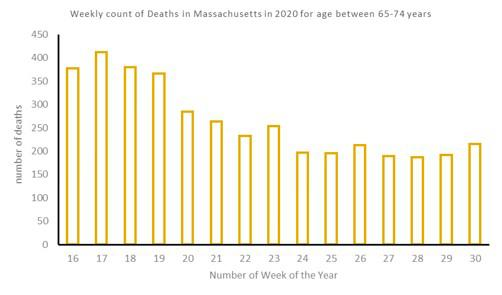

<IPython.core.display.Javascript object>

In [33]:
print(DATA.train_dataset[0].target_string)
torchvision.transforms.functional.to_pil_image(DATA.train_dataset[0].image)

## Model <span id=Model_></span>

In [4]:
transformers.processing_utils.ProcessorMixin?

<IPython.core.display.Javascript object>

In [ ]:
transformers.VisionEncoderDecoderModel.to

In [12]:
de = transformers.VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base"
)

<IPython.core.display.Javascript object>

In [9]:
donut_processor = transformers.DonutProcessor.from_pretrained(
    "naver-clova-ix/donut-base"
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


<IPython.core.display.Javascript object>

In [34]:
CONFIG.pretrained_model_name = "naver-clova-ix/donut-base"
CONFIG.encoder_decoder_config = transformers.VisionEncoderDecoderConfig.from_pretrained(
    CONFIG.pretrained_model_name
)
CONFIG.encoder_decoder_config.encoder.image_size = (
    CONFIG.image_width,
    CONFIG.image_height,
)

MODEL.donut_processor = transformers.DonutProcessor.from_pretrained(
    CONFIG.pretrained_model_name
)
MODEL.donut_processor.image_processor.size = dict(
    width=CONFIG.image_width, height=CONFIG.image_height
)
MODEL.donut_processor.image_processor.do_align_long_axis = False
MODEL.tokenizer = MODEL.donut_processor.tokenizer
MODEL.encoder_decoder = transformers.VisionEncoderDecoderModel.from_pretrained(
    CONFIG.pretrained_model_name, config=CONFIG.encoder_decoder_config
)

CONFIG.encoder_decoder_config.pad_token_id = MODEL.tokenizer.pad_token_id
CONFIG.encoder_decoder_config.decoder_start_token_id = (
    MODEL.tokenizer.convert_tokens_to_ids(TOKEN.benetech_prompt)
)
CONFIG.encoder_decoder_config.bos_token_id = (
    CONFIG.encoder_decoder_config.decoder_start_token_id
)
CONFIG.encoder_decoder_config.eos_token_id = MODEL.tokenizer.convert_tokens_to_ids(
    TOKEN.benetech_prompt_end
)
MODEL.tokenizer.eos_token_id = CONFIG.encoder_decoder_config.eos_token_id

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


<IPython.core.display.Javascript object>

### Add task specific tokens <span id=Add_task_specific_tokens_></span>

In [35]:
def add_unknown_tokens_to_tokenizer(unknown_tokens: list[str]):
    assert set(unknown_tokens) == set(unknown_tokens) - set(
        MODEL.tokenizer.vocab.keys()
    ), "Tokens are not unknown."

    MODEL.tokenizer.add_tokens(unknown_tokens)
    MODEL.encoder_decoder.decoder.resize_token_embeddings(len(MODEL.tokenizer))

<IPython.core.display.Javascript object>

In [36]:
add_unknown_tokens_to_tokenizer(list(TOKEN.__dict__.values()))

<IPython.core.display.Javascript object>

### Add dataset specific tokens <span id=Add_dataset_specific_tokens_></span>

In [37]:
def find_unknown_tokens_for_tokenizer() -> collections.Counter:
    unknown_tokens_counter = collections.Counter()

    for annotated_image in generate_annotated_images():
        ground_truth = get_annotation_ground_truth_str(annotated_image.annotation)

        input_ids = MODEL.tokenizer(ground_truth).input_ids
        tokens = MODEL.tokenizer.tokenize(ground_truth, add_special_tokens=True)

        for token_id, token in zip(input_ids, tokens, strict=True):
            if token_id == MODEL.tokenizer.unk_token_id:
                unknown_tokens_counter.update([token])

    return unknown_tokens_counter

<IPython.core.display.Javascript object>

In [38]:
if DEBUG:
    print(find_unknown_tokens_for_tokenizer())

<IPython.core.display.Javascript object>

In [39]:
CONFIG.unknown_tokens_for_tokenizer_path = "data/unknown_tokens_for_tokenizer.pickle"

add_unknown_tokens_to_tokenizer(
    load_pickle_or_build_object_and_save(
        CONFIG.unknown_tokens_for_tokenizer_path,
        lambda :list(find_unknown_tokens_for_tokenizer().keys())
    )
)

<IPython.core.display.Javascript object>

In [40]:
def compute_target_tokens_length_distribution():
    token_lenghts = []
    for data_item in tqdm.autonotebook.tqdm(
        DATA.complete_dataset, desc="Encoding target strings"
    ):
        encoding = MODEL.tokenizer(data_item.target_string)
        token_lenghts.append(len(encoding.input_ids))
    return token_lenghts


def visualize_target_tokens_length_distribution():
    token_lenghts = compute_target_tokens_length_distribution()
    plt.hist(token_lenghts, bins=50)
    plt.title("Token length")
    series = pd.Series(token_lenghts, name="Token length").to_frame().describe()
    IPython.display.display(series)

<IPython.core.display.Javascript object>

In [41]:
if DEBUG:
    visualize_target_tokens_length_distribution()

<IPython.core.display.Javascript object>

In [42]:
CONFIG.encoder_decoder_config.decoder.max_length = 512

<IPython.core.display.Javascript object>

### Predicting <span id=Predicting_></span>

In [43]:
def generate_token_strings(images: torch.Tensor, skip_special_tokens=True) -> list[str]:
    decoder_output = MODEL.encoder_decoder.generate(
        images,
        max_length=10 if DEBUG else CONFIG.encoder_decoder_config.decoder.max_length,
        eos_token_id=MODEL.tokenizer.eos_token_id,
        return_dict_in_generate=True,
    )
    return MODEL.tokenizer.batch_decode(
        decoder_output.sequences, skip_special_tokens=skip_special_tokens
    )


def predict_string(image) -> str:
    image = MODEL.donut_processor(
        image, random_padding=False, return_tensors="pt"
    ).pixel_values
    string = generate_token_strings(image)[0]
    return string


def predict_benetech_output(image):
    string = predict_string(image)
    assert BenetechOutput.does_string_match_expected_pattern(string)
    return BenetechOutput.from_string(string)

<IPython.core.display.Javascript object>

### Dataloader <span id=Dataloader_></span>

In [44]:
@dataclasses.dataclass
class Batch:
    images: torch.FloatTensor
    labels: torch.IntTensor
    data_indices: list[int]

    def __post_init__(self):
        if DEBUG:
            images_shape = einops.parse_shape(self.images, "batch channel height width")
            labels_shape = einops.parse_shape(self.labels, "batch label")
            assert images_shape["batch"] == labels_shape["batch"]
            assert len(self.data_indices) == images_shape["batch"]


def replace_pad_token_id_with_negative_hundred_for_hf_transformers_automatic_batch_transformation(
    token_ids,
):
    token_ids[token_ids == MODEL.tokenizer.pad_token_id] = -100
    return token_ids


def collate_function(batch: list[DataItem], split: Literal["train", "val"]) -> Batch:
    images = [di.image for di in batch]
    images = MODEL.donut_processor(
        images, random_padding=split == "train", return_tensors="pt"
    ).pixel_values

    target_token_ids = MODEL.tokenizer(
        [di.target_string for di in batch],
        add_special_tokens=False,
        max_length=CONFIG.encoder_decoder_config.decoder.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ).input_ids
    labels = replace_pad_token_id_with_negative_hundred_for_hf_transformers_automatic_batch_transformation(
        target_token_ids
    )

    data_indices = [di.data_index for di in batch]

    return Batch(images=images, labels=labels, data_indices=data_indices)


CONFIG.batch_size = 2 if DEBUG else 2
CONFIG.num_workers = 4


def build_dataloader(split: Literal["train", "val"]):
    return torch.utils.data.DataLoader(
        DATA.train_dataset if split == "train" else DATA.val_dataset,
        batch_size=CONFIG.batch_size,
        shuffle=split == "train",
        num_workers=CONFIG.num_workers,
        collate_fn=functools.partial(collate_function, split=split),
    )


DATA.train_dataloader = build_dataloader("train")
DATA.val_dataloader = build_dataloader("val")

<IPython.core.display.Javascript object>

In [45]:
def test_dataloaders():
    for batch in tqdm.autonotebook.tqdm(
        DATA.val_dataloader, "Iterating over val dataloader"
    ):
        pass
    for batch in tqdm.autonotebook.tqdm(
        DATA.train_dataloader, "Iterating over train dataloader"
    ):
        pass

<IPython.core.display.Javascript object>

In [46]:
if DEBUG:
    test_dataloaders()

<IPython.core.display.Javascript object>

### Lightning module <span id=Lightning_module_></span>

In [47]:
CONFIG.learning_rate = 3e-5


class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MODEL.encoder_decoder

    def training_step(self, batch: Batch, batch_idx: int) -> torch.Tensor:
        outputs = self.model(pixel_values=batch.images, labels=batch.labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: Batch, batch_idx: int, dataset_idx: int = 0):
        outputs = self.model(pixel_values=batch.images, labels=batch.labels)
        loss = outputs.loss
        self.log("val_loss", loss)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=CONFIG.learning_rate)
        return optimizer


MODEL.lightning_module = LightningModule()

<IPython.core.display.Javascript object>

### Callbacks <span id=Callbacks_></span>

In [48]:
class MetricsCallback(pl.callbacks.Callback):
    def on_validation_batch_start(
        self, trainer, pl_module, batch: Batch, batch_idx, dataloader_idx=0
    ):
        predicted_strings = generate_token_strings(images=batch.images)

        for expected_data_index, predicted_string in zip(
            batch.data_indices, predicted_strings, strict=True
        ):
            benetech_score = benetech_score_string_prediction(
                expected_data_index=expected_data_index,
                predicted_string=predicted_string,
            )
            wandb.log(dict(benetech_score=benetech_score))

        ground_truth_strings = [
            get_annotation_ground_truth_str_from_image_index(i)
            for i in batch.data_indices
        ]
        string_ids = [load_train_image_ids()[i] for i in batch.data_indices]
        strings_dataframe = pd.DataFrame(
            dict(
                string_ids=string_ids,
                ground_truth=ground_truth_strings,
                predicted=predicted_strings,
            )
        )
        wandb.log(dict(strings=wandb.Table(dataframe=strings_dataframe)))


class TransformersCheckpointIO(pl.plugins.CheckpointIO):
    def save_checkpoint(self, checkpoint, path, storage_options=None):
        MODEL.donut_processor.save_pretrained(path)
        MODEL.encoder_decoder.save_pretrained(path)

    def load_checkpoint(self, path, storage_options=None):
        pass

    def remove_checkpoint(self, path):
        pass

<IPython.core.display.Javascript object>

## Training <span id=Training_></span>

In [49]:
TRAINING.accelerator = "cpu" if DEBUG else "gpu"
TRAINING.devices = "auto" if TRAINING.accelerator == "cpu" else [3]
TRAINING.directory = "training"
TRAINING.save_top_k_checkpoints = 3
TRAINING.wandb_project_name = "MakingGraphsAccessible"
TRAINING.limit_train_batches = 2 if DEBUG else None
TRAINING.limit_val_batches = 2 if DEBUG else 0.1

TRAINING.model_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=TRAINING.directory,
    monitor="val_loss",
    save_top_k=TRAINING.save_top_k_checkpoints,
)

TRAINING.logger = pl.loggers.WandbLogger(
    project=TRAINING.wandb_project_name, save_dir=TRAINING.directory
)

TRAINING.trainer = pl.Trainer(
    accelerator=TRAINING.accelerator,
    devices=TRAINING.devices,
    plugins=[TransformersCheckpointIO()],
    callbacks=[TRAINING.model_checkpoint, MetricsCallback()],
    logger=TRAINING.logger,
    limit_train_batches=TRAINING.limit_train_batches,
    limit_val_batches=TRAINING.limit_val_batches,
)

wandb: Currently logged in as: dkoshman. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

In [50]:
TRAINING.trainer.fit(
    model=MODEL.lightning_module,
    train_dataloaders=DATA.train_dataloader,
    val_dataloaders=DATA.val_dataloader,
)

/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/dkkoshman/YSDA/machine_learning/transformers/MakingGraphsAccessible/training exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  

Sanity Checking: 0it [00:00, ?it/s]

/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

ValueError: could not convert string to float: ' 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01</benetech_prompt> 3.44975e-01'

<IPython.core.display.Javascript object>

In [ ]:
TRAINING.trainer.validate(model=MODEL.lightning_module, dataloaders=DATA.val_dataloader)

## Results <span id=Results_></span>

### Gradio interface <span id=Gradio_interface_></span>

In [ ]:
checkpoint_path = "training/epoch=0-step=2-v1.ckpt"
MODEL.donut_processor = MODEL.donut_processor.from_pretrained(checkpoint_path)
MODEL.encoder_decoder = MODEL.encoder_decoder.from_pretrained(checkpoint_path)

In [ ]:
interface = gradio.Interface(
    fn=predict_string,
    inputs=gradio.Image(type="pil"),
    outputs=gradio.Text(),
    examples="examples",
)

In [ ]:
interface.launch(share=True)